<a href="https://www.kaggle.com/code/mikekubal/passprotectionproficiency?scriptVersionId=115934238" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# README for PassProtectionProficiency Notebook

The PPP statistic might be a quarterback's and general manager's new best friend.

The average NFL team pays it top 5 lineman a total of about 23 million dollars per year
with a 53% chance of an offensive line related negative event on a passing play (lineman beat, or quarterback hurried or hit or sacked).

Leveraging PPP, a team could conceivably reduce their chance of a negative event to 19% on every passing plaay by spending an additional 4 million dollars per year. If a team could sign the 5 players with the higest PPP scores, their salaries would total about 27M dollars per year.

Surprisingly, if a team were to sign the 5 highest paid offensive lineman, their salaries would total about 74 millions dollars per year, but the chance of a negative event on a passing play would still be a whopping 44% (for breakdown of above please see last cell in notebook,'cell-19, Discussion of PPP Impact').

Initial exploration of player data (PPP derived from pffScouting, physical attributes, Combine, salary) showed that experience (using age as a proxy) is
better correlated with PPP than athleticism (see cell-15 in notebook).

The analysis suggests that NFL teams are not optimal in aligning offensive line salaries with PPP (see cell-15 in notebook).
The mystery of how offensive lineman salaries are set is not revealed by the analysis.
This analysis did not inlcude run blocking proficiency which could explain some of the seeming misalignment of salary with performance.

Perhaps the most novel and hopefuly useful aspect of the analysis is that it provides support for my 'weak-link-in-the-chain' theory.
Smart defensive coordiantors have figured out that it only takes one defender in the backfield to blow-up a play.
Fittingly they will look for the match-up against the 'weak link' in the offesnsive line.
Knowing this, offensive lines should attempt to balance the PPP across the line, maximizing the PPP of their weakest player.
The analysis shows offensive lines with this characteristic achieve a better overall team PPP (see cell-18 in notebook).
Dependent on how the data is prepared the overall Team PPP is equally or more correlated with the weakest PPP (among the top 5)
than the strongest PPP among the top 5 highest paid.

However, this may be a happy accident for some of these teams.
Looking at the average offensive line salary distribution across teams (see cell-19 in notebook),
one might conclude that having a tackle 'super' block his defender somehow offsets the guard's poor pass blocking.

Conclusion:
When it comes building an offensive line that is effective at pass protection,
teams should consider building a line that is optimally balanced in respect to PPP with no weak spots,
seeking candidates among the more experienced that have demostrated pass-blocking skill (according to PPP),
with less focus on physical attributes and athleticism.

Future Work:
I would like to build a Bayesian predictive model that leverages PPP
and can calculate risk of negative event in real-time based on context of the play:
1. play called
2. specific offensive lineman in game
3. field postion
4. score and quarter
5. specific defenders in game
6. defensive alignment
7. QB mobility
8. QB decision-making

This repository contains 'PPP_Analysis.ipynb' notebook (and data files) which walks through the analysis summarized above.

#Cell-1
This notebook contains the steps for 
calculating new statistic, PassProtectionProficiency (PPP).
It then explores how it might be combined with other 
offensive lineman attrributes and salary information
to evaluate my weak-link theory as described 
in https://github.com/mikekubal/PassProtectionProficiency/edit/main/README.md.

Outline:
1. New statistic PPP (pass-protection-proficiency) is metric for measuring individual or team performance.
2. Salaries for offensive linemen in NFL are more correlated with athlectic ability than PPP.
3. Overall team PPP is more correlated with maximizing proficency of weakest blocker than strongest blocker.
4. Implications

#1.PPP (pass-protection-proficiency) is metric for measuring individual or team performance.
PPP is simply a ratio of total plays where a linemen was in pass protection role to
total negative events (lineman got beat or was responsible for QB being pressured, hit or sacked).
A PPP of 10 equates to a ration of 9 positive plays to 1 negative play. 
A positive play is simply a passing play without a negative event.

In [3]:
#Cell-2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [5]:
#Cell-3
#pull attributes on offensive linemen and store
#in a set of player_* dictionaries
#data taken from oline_players.csv, a subset of provided data: players.csv

#capture general player info
players = {} #key is player id
player_name = {} #key is id and value is name
player_ht = {}
player_wt = {}
player_age = {}

#capture individual player performance
pp_plays_total = {}
#player_good_to_bad captures ratio total pass-protection plays 
#to negative pass blocking events
#higher is better : )
player_good_to_bad = {} 
beats_allowed = {}
hits_allowed = {}
hurries_allowed = {}
sacks_allowed = {}
sacker = {}

#capture aggregate team performance
team_pp_plays_total = {}
#team_good_to_bad is ratio total pass protection plays
#to negative pass blocking events
team_good_to_bad = {}
team_beats_allowed = {}
team_hits_allowed = {}
team_hurries_allowed = {}
team_sacks_allowed = {}
        
player_file = open("/kaggle/input/ppp-bigdatabowl/BigDataBowl_Kaggle_Submission/Contest_Provided_Data/oline_players.csv","r")
for l in player_file:
        #print(parts[6])
        parts = l.split(",")
        players[parts[0]] = 1
        ht_parts= parts[1].split("-")
        #height is recorded as inches above 6 ft
        ht = ht_parts[1].replace("\"","")
        player_ht[parts[0]] = ht
        player_wt[parts[0]] = int(parts[2])
        birthdate = parts[3].split("-")
        year = birthdate[0]
        year = year.replace("\"","")
        if year != 'NA':
            age = 2023 - int(year)
            player_age[parts[0]] = age
        else:
            #replace later wiuth average
            player_age[parts[0]] = 26
        name = parts[6].replace("\"","")
        name = name.strip("\n")
        player_name[parts[0]] = name       
        pp_plays_total[parts[0]] = 0
        beats_allowed[parts[0]] = 0
        hits_allowed[parts[0]] = 0
        hurries_allowed[parts[0]] = 0
        sacks_allowed[parts[0]] = 0
        player_good_to_bad[parts[0]] = 0
player_file.close()

In [6]:
#Cell-4
#organize salary data 
#from https://www.spotrac.com/nfl/positional/breakdown/
#into dictionaries

salary_name = {}
salary_name_to_pos = {}
salary_name_to_dollars = {}
salary_name_to_team = {}

#the following team_* stats are based on top 5 highest paid o-linemen
#and are measured in dollars
team_avg = {}
team_sum = {}
team_variance = {}
salary_rank_1 = []
salary_rank_2 = []
salary_rank_3 = []
salary_rank_4 = []
salary_rank_5 = []

#salaries are listed highest to lowest so taking first 5 player
#for each team is all that is needed for current analysis

player_file = open("/kaggle/input/ppp-bigdatabowl/BigDataBowl_Kaggle_Submission/Supplemental_Public_Data/salaries.txt","r")
team = "none"
count = 0
sum = 0
avg = 0
variance = 0
salaries_list = []

for l in player_file:
    l = l.strip("\n")
    x = re.search("^[A-Z]+", l)
    if(x):
        team = x[0]
        count = 0
        sum = 0
        avg = 0
        weakest_ppp = 100
        variance = 0
        salaries_list = []
    else:
        parts = l.split("\t")
        if(len(parts) > 4):
            name = parts[1]        
            position = parts[3]
            dollars = parts[4].replace("$","")
            dollars = dollars.replace(",","")
            
            if(count < 5 ):
                sum = sum + int(dollars)
                count = count + 1
                salaries_list.append(int(dollars))
                salary_name[name] = 1
                salary_name_to_pos[name] = position
                salary_name_to_dollars[name] = (float(dollars)/1000000)
                salary_name_to_team[name] = team
                if(count == 1):
                    salary_rank_1.append(int(dollars))
                elif(count == 2):
                    salary_rank_2.append(int(dollars))
                elif(count == 3):
                    salary_rank_3.append(int(dollars))
                elif(count == 4):
                    salary_rank_4.append(int(dollars))
                elif(count == 5):
                    salary_rank_5.append(int(dollars))
                                     

            if(count == 5):
                avg = (sum / 5)
                sum_of_squares = 0
                for s in salaries_list:
                    sum_of_squares = ((avg - s)**2) + sum_of_squares
                variance = (1/(sum_of_squares / 5))
                #print(variance)  
                team_avg[team] = avg
                team_sum[team] = sum
                team_variance[team] = variance
                count = count + 1

In [7]:
#Cell-5
#capture aggregate team performance
team_pp_plays_total = {}
#team_good_to_bad is ratio total pass protection plays
#to negative pass blocking events
team_good_to_bad = {}
team_beats_allowed = {}
team_hits_allowed = {}
team_hurries_allowed = {}
team_sacks_allowed = {}

teams = (["TB","CIN","NYJ","DAL","MIA","ATL","PHI","BUF","ARI","WAS","NYG","PIT",
          "CAR","TEN","BAL","MIN","CHI","DET","SF","HOU","JAX","KC","IND","SEA",
          "LA","LAC","CLE","NE","NO","DEN","GB","LV"])

In [9]:
#Cell-6
#taking data from provided pffScoutingData.csv 
#tally total number of plays 
#where oline player (Center, Guard, Tackle) was in pass protection role
#and negative result occured: beat, hurried, hit, sacked

#also aggregate data for each team to generate team PPP

#also capture counts of sacks for each defender for
#possible use later in 'sacker' dictionary

scout_file = open("/kaggle/input/ppp-bigdatabowl/BigDataBowl_Kaggle_Submission/Contest_Provided_Data/pffScoutingData.csv","r")
for l in scout_file:
    salary_info = 0
    parts = l.split(",")
    player = parts[2]
    team = ""
    if player in players.keys():
        if(player_name[player]):
            name = player_name[player]
            if(name in salary_name):
                salary_info = 1
                team = salary_name_to_team[name]
            else:
                salary_info = 0
        beaten = parts[8]
        hit = parts[9]
        hurry = parts[10]
        sack = parts[11]
        defender =  parts[12]
        role = parts[13]
        #check to see if player was in Pass Protection Role
        if (role == "\"PP\""):
            pp_plays_total[player] = pp_plays_total[player] + 1
            if beaten == "1":
                    beats_allowed[player] = beats_allowed[player] + 1
                    #print("here")
            if hit == "1":
                    hits_allowed[player] = hits_allowed[player] + 1
            if hurry == "1":
                    hurries_allowed[player] = hurries_allowed[player] + 1
            if sack == "1":
                sacks_allowed[player] = sacks_allowed[player] + 1
                if defender not in sacker.keys():
                        sacker[defender] = 1
                else:
                        sacker[defender] =  sacker[defender] + 1
            if(team):
                    if team in team_pp_plays_total:
                        team_pp_plays_total[team] = team_pp_plays_total[team] + 1
                    else:
                        team_pp_plays_total[team] = 1
                    
                    if beaten == "1":
                        if team in team_beats_allowed:
                            team_beats_allowed[team] = team_beats_allowed[team] + 1
                        else:
                            team_beats_allowed[team] = 1 
                    if hit == "1":
                        if team in team_hits_allowed:
                            team_hits_allowed[team] = team_hits_allowed[team] + 1
                        else:
                            team_hits_allowed[team] = 1
                    if hurry == "1":
                        if team in team_hurries_allowed:   
                            team_hurries_allowed[team] = team_hurries_allowed[team] + 1
                        else:
                            team_hurries_allowed[team] = 1
                    if sack == "1":
                        if team in team_sacks_allowed:   
                            team_sacks_allowed[team] = team_sacks_allowed[team] + 1
                        else:
                            team_sacks_allowed[team] = 1
                    team = ""
#for team in teams:
#    print(team + " sacks allowed " + str(team_sacks_allowed[team])) 
#    print(team + " hits allowed " + str(team_hits_allowed[team]))
#    print(team + " hurries allowed " + str(team_hurries_allowed[team]))
#    print(team + " beats allowed " + str(team_beats_allowed[team]))

In [10]:
#categories where teams had no occurences of these negative events
team_sacks_allowed["SEA"] = 0
team_sacks_allowed["LV"] = 0
team_hits_allowed["KC"] = 0

In [11]:
#Cell-7
#tally negative pass plays for each team
for team in teams:
    #print(team)
    bad_sum = (
         team_sacks_allowed[team] 
       + team_hits_allowed[team]
       + team_hurries_allowed[team]
       + team_beats_allowed[team] 
    )
    #print(bad_sum)
    total_plays = team_pp_plays_total[team]
    #print(total_plays)
    team_good_to_bad[team] = round((total_plays/ bad_sum),2)

In [12]:
#Cell-8
sum = 0
avg_salary_rank_1 = 0
avg_salary_rank_2 = 0
avg_salary_rank_3 = 0
avg_salary_rank_4 = 0
avg_salary_rank_5 = 0
avg_salary_by_rank = []

count = len(salary_rank_1)

for s in salary_rank_1:
    sum = sum + s
avg_salary_rank_1 =  (sum/count)/1000000
avg_salary_by_rank.append(round(avg_salary_rank_1,0))
sum = 0

for s in salary_rank_2:
    sum = sum + s
avg_salary_rank_2 =  (sum/count)/1000000
avg_salary_by_rank.append(round(avg_salary_rank_2,0))
sum = 0

for s in salary_rank_3:
    sum = sum + s
avg_salary_rank_3 =  (sum/count)/1000000
avg_salary_by_rank.append(round(avg_salary_rank_3,0))
sum = 0

for s in salary_rank_4:
    sum = sum + s
avg_salary_rank_4 =  (sum/count)/1000000
avg_salary_by_rank.append(round(avg_salary_rank_4,0))
sum = 0

for s in salary_rank_5:
    sum = sum + s
avg_salary_rank_5 =  (sum/count)/1000000
avg_salary_by_rank.append(round(avg_salary_rank_5,0))
sum = 0    

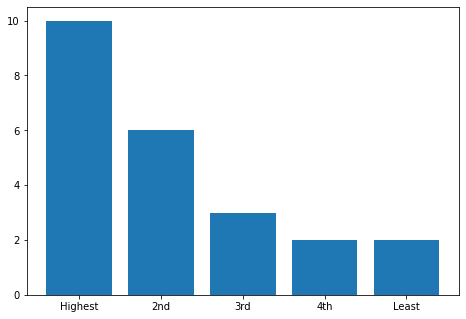

In [13]:
#Cell-9
#Distribution of Average 5 Highest-Paid Offensive Linemen on Across All Teams

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ranks = ['Highest', '2nd', '3rd', '4th', 'Least']
ax.bar(ranks,avg_salary_by_rank)
plt.show()
#y-axis in Millions of $ per year

#As displayed below, offense line salary distributions have one highly paid player
#and a large differential between that player and the 4th and 5th highest-paid offensive linemen on each team.
#The salary distributions across o-linemen suggest it is better for a defender to be 'super-blocked',
#by one highly-paid blocker, and paying a steep premium to do so.
#The downstream analysis suggests having a more balanced line block 'just well-enough'
#and (maximizing the PPP of weakest link) may be preferable.


In [14]:
#Cell-10
#in following captures combine data from 2000-2022 from as many O-linemen
#as possible
#this data comes from combines 2000-2022 from https://www.pro-football-reference.com
#due to special characters and/or transitions from excel to csv
#this data required some cleanup, this data is loaded from 2 different csv files
#and tab delimited text file  

combine_f = open("/kaggle/input/ppp-bigdatabowl/BigDataBowl_Kaggle_Submission/Supplemental_Public_Data/p1_OL_2000_2022_combine_results.csv","r")
combine_player = {}
combine_40 = {} #col5
combine_broad = {} #col8
combine_shuttle = {} #col10
combine_bench = {} #col7
combine_cone = {} #col9
combine_vertical = {} #col6

count = 0
for l in combine_f:
    parts = l.split(",")
    player = parts[0]
    #print(player)
    count = count + 1
    combine_player[player] = 1
    combine_40[player] = parts[4] #col5
    combine_vertical[player] = parts[5] #col6
    combine_broad[player] = parts[7] #col8
    combine_shuttle[player] = parts[9] #col10
    combine_bench[player] = parts[6] #col7
    combine_cone[player] = parts[8] #col9
    
combine_f.close()
#print(count)

combine_f = open("/kaggle/input/ppp-bigdatabowl/BigDataBowl_Kaggle_Submission/Supplemental_Public_Data/p2_OL_2000_2022_combine_results.txt","r")
count = 0
for l in combine_f:
    parts = l.split("\t")
    player = parts[0]
    #print(player)
    count = count + 1
    combine_player[player] = 1
    combine_40[player] = parts[3] #col4
    combine_vertical[player] = parts[5] #col6
    combine_broad[player]= parts[6] #col7
    combine_shuttle[player] = parts[8] #col9
    combine_bench[player] = parts[5] #col6
    combine_cone[player] = parts[7] #col8
    
combine_f.close()
#print(count)

combine_f = open("/kaggle/input/ppp-bigdatabowl/BigDataBowl_Kaggle_Submission/Supplemental_Public_Data/p3_OL_2000_2022_combine_results.csv","r")
count = 0
for l in combine_f:
    parts = l.split(",")
    player = parts[0]
    #print(player)
    count = count + 1
    combine_player[player] = 1
    combine_40[player] = parts[4] #col5
    combine_vertical[player] = parts[5] #col6
    combine_broad[player] = parts[7] #col8
    combine_shuttle[player] = parts[9] #col10
    combine_bench[player] = parts[6] #col7
    combine_cone[player] = parts[9] #col9
    
combine_f.close()

In [15]:
#Cell-11
#compute the average 40, bench, broad jump, vertical,
#shuttle run and cone run to be used in filling in gaps
#in the matrix when a player did not have one recorded at the combine

forty_count = 0
broad_count = 0
shuttle_count =  0
bench_count = 0
cone_count = 0 
vertical_count = 0
salary_count = 0

forty_total = 0
broad_total = 0
shuttle_total =  0
bench_total = 0
cone_total = 0
vertical_total = 0 
salary_total = 0

count = 0
for player in player_name.keys():
    name = player_name[player]
    if name in combine_player.keys():
        #print("yes")
        count = count + 1
        if(combine_40[name]):
            forty_total =  forty_total + float(combine_40[name])
            forty_count = forty_count + 1
            
        if(combine_vertical[name]):
            vertical_total =  vertical_total + float(combine_vertical[name])
            vertical_count = vertical_count + 1
            
        if(combine_broad[name]):
            broad_total =  broad_total + float(combine_broad[name])
            broad_count = broad_count + 1

        if(combine_shuttle[name]):
            try:
                shuttle_total =  shuttle_total + float(combine_shuttle[name])
                shuttle_count = shuttle_count + 1
            except:
                do_nothing = 1
                #print("oops")
            
        if(combine_bench[name]):
            bench_total =  bench_total + float(combine_bench[name])
            bench_count = bench_count + 1
            
        if(combine_cone[name]):
            cone_total =  cone_total + float(combine_cone[name])
            cone_count = cone_count + 1
        if(name in salary_name_to_dollars):
            salary_total =  salary_total + float(salary_name_to_dollars[name])
            salary_count = salary_count + 1

avg_forty = (forty_total/forty_count)
avg_broad = (broad_total/broad_count)
avg_shuttle =  (shuttle_total/shuttle_count)
avg_bench = (bench_total/bench_count)
avg_cone = (cone_total/bench_count)
avg_vertical = (vertical_total/vertical_count)
avg_salary = (salary_total/salary_count)

In [18]:
#Cell-12
#create matrix file that integrates 
#individual PPP score with a player's attributes, 
#combine data and salary

mf = open("matrix.txt","w")
mf.write("Score\tHeight\tWeight\tAge\t40\tVertical\tBroad\tBench\tShuttle\tCone\tSalary\n")

for player in pp_plays_total.keys():
    bad_sum = (
     sacks_allowed[player] 
     + hits_allowed[player]
     + hurries_allowed[player]
     + beats_allowed[player] + 1)
    
    player_good_to_bad[player] = round((pp_plays_total[player]/ bad_sum),2)
    name = player_name[player]
    
    forty = 0
    vertical = 0
    bench = 0
    broad = 0
    shuttle = 0
    cone = 0
  
    if name in combine_player.keys():
        #print("yes")
        count = count + 1
        if(combine_40[name]):
            forty = combine_40[name]
        else:
            forty = avg_forty
            
        if(combine_vertical[name]):
            vertical = combine_vertical[name]
        else:
            vertical = avg_vertical
            
        if(combine_broad[name]):
            broad = combine_broad[name]
        else:
            broad = avg_broad
            
        if(combine_shuttle[name]):
            shuttle = combine_shuttle[name]
        else:
            shuttle = avg_shuttle
            
        if(combine_bench[name]):
            bench = combine_bench[name]
        else:
            bench = avg_bench
        
        if(combine_cone[name]):
            cone = combine_cone[name]
        else:
             cone = avg_cone
        if(name in salary_name_to_dollars):
            salary = salary_name_to_dollars[name]
        else:
             salary = avg_salary
    mf.write(
        str(player_good_to_bad[player])
        +"\t"+str(player_ht[player])
        +"\t"+str(player_wt[player]) 
        +"\t"+str(player_age[player])
        +"\t"+str(forty)
        +"\t"+str(vertical)
        +"\t"+str(broad)
        +"\t"+str(bench)
        +"\t"+str(shuttle)
        +"\t"+str(cone)
        +"\t"+str(salary)
        + "\n"
            )
mf.close()

In [19]:
#Cell-13
#let's do some basic exploration of the data
#using all attributes and continuous score
df= pd.read_csv('/kaggle/working/matrix.txt', sep='\t')
df = df.dropna()
df.head(5)

,Score,Height,Weight,Age,40,Vertical,Broad,Bench,Shuttle,Cone,Salary
0,7.33,4.0,328.0,41.0,4.93,29.000000,115.00,21.000000,4.750000,4.750000,1.826731
1,10.32,7.0,330.0,42.0,5.16,30.500000,112.00,28.000000,4.830000,4.830000,4.765159
2,6.09,4.0,315.0,38.0,5.07,27.500000,105.00,24.000000,4.520000,4.520000,3.696000
3,22.00,4.0,330.0,36.0,5.28,28.321918,106.68,25.381579,4.704266,5.828487,4.765159
4,10.78,5.0,320.0,35.0,4.81,34.500000,113.00,23.000000,4.630000,4.630000,9.671765


In [20]:
#Cell-14
df.describe()

,Score,Height,Weight,Age,40,Vertical,Broad,Bench,Shuttle,Cone,Salary
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,7.923750,4.891129,314.282258,29.274194,3.430335,18.775133,70.309839,16.593591,3.110561,4.014691,4.641755
std,5.690897,1.495013,13.074412,3.124511,2.463477,13.624161,50.630568,12.465997,2.234498,3.073739,2.648372
min,0.000000,1.000000,260.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.795556
25%,4.767500,4.000000,307.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.255374
50%,6.775000,5.000000,314.000000,29.000000,5.100000,27.000000,104.000000,23.000000,4.620000,4.785000,4.765159
75%,9.232500,6.000000,320.250000,31.000000,5.220000,28.500000,106.760000,25.381579,4.704266,5.828487,4.765159
max,44.670000,9.000000,380.000000,42.000000,5.850000,34.500000,121.000000,44.000000,5.380000,8.410000,18.400000


In [21]:
#Cell-15
df.corr()
#Age/Experience has best correlation with PPP Score.
#Note as 40-yard dash, shuttle run and cone run are times, a negative correlation means a faster time
#is correlated with a better PPP score, though interestingly only very slightly.

,Score,Height,Weight,Age,40,Vertical,Broad,Bench,Shuttle,Cone,Salary
Score,1.000000,-0.228054,0.006042,0.222844,-0.077974,-0.065410,-0.075674,-0.029460,-0.075352,-0.048797,0.141545
Height,-0.228054,1.000000,0.278921,-0.054254,0.028437,0.034442,0.036970,-0.010567,0.034041,-0.079596,0.106092
Weight,0.006042,0.278921,1.000000,0.069454,-0.016277,-0.051532,-0.040249,-0.037748,-0.012142,-0.063473,0.019472
Age,0.222844,-0.054254,0.069454,1.000000,-0.116700,-0.102516,-0.110758,-0.116147,-0.118206,-0.151697,0.104588
40,-0.077974,0.028437,-0.016277,-0.116700,1.000000,0.982819,0.991687,0.949159,0.998377,0.936735,0.152268
Vertical,-0.065410,0.034442,-0.051532,-0.102516,0.982819,1.000000,0.993012,0.955165,0.983481,0.917943,0.173043
Broad,-0.075674,0.036970,-0.040249,-0.110758,0.991687,0.993012,1.000000,0.955986,0.991648,0.927609,0.165107
Bench,-0.029460,-0.010567,-0.037748,-0.116147,0.949159,0.955165,0.955986,1.000000,0.950302,0.917496,0.188511
Shuttle,-0.075352,0.034041,-0.012142,-0.118206,0.998377,0.983481,0.991648,0.950302,1.000000,0.935755,0.154181
Cone,-0.048797,-0.079596,-0.063473,-0.151697,0.936735,0.917943,0.927609,0.917496,0.935755,1.000000,0.131827


In [22]:
#loop through all teams top 5 highest paid players, and find weakest ppp
#make table of weakest ppp and team ppp

tf = open("team_matrix.txt", "w")
tf.write("Team\tTeamPPP\tWeakest\tStrongest\tDelta\tAvgSalary\tSumOfSalaries\n")
team_weakest_ppp = {}
team_weakest_ppp = {}
team_strongest_ppp = {}

for id in player_name.keys():
    #print(id)
    if player_name[id] in salary_name_to_dollars:
        name = player_name[id]
        ppp = player_good_to_bad[id]
        if(ppp > 0):
            if name in salary_name_to_team:
                team = salary_name_to_team[name]
                #print(team)
                if (team in team_weakest_ppp):
                    if (ppp < team_weakest_ppp[team]):
                        team_weakest_ppp[team] = ppp
                else:
                    team_weakest_ppp[team] = ppp

                if (team in team_strongest_ppp):
                    if (ppp > team_strongest_ppp[team]):
                        team_strongest_ppp[team] = ppp
                else:
                    team_strongest_ppp[team] = ppp
for team in team_weakest_ppp:
    team_ppp = team_good_to_bad[team]
    weakest_ppp = team_weakest_ppp[team]
    strongest_ppp = team_strongest_ppp[team]
    delta = strongest_ppp - weakest_ppp
    tf.write((team + 
              "\t" + str(team_ppp) + 
              "\t" + str(weakest_ppp) + 
              "\t" + str(strongest_ppp) + 
              "\t" + str(round(delta,2)) + 
              "\t" + str(team_avg[team]) +
              "\t" + str(team_sum[team]) + 
              "\n"))
tf.close()

In [23]:
#Cell-17
df= pd.read_csv('/kaggle/working/team_matrix.txt', sep='\t')
df = df.dropna()
df.head(5)

,Team,TeamPPP,Weakest,Strongest,Delta,AvgSalary,SumOfSalaries
0,DAL,8.62,7.33,10.29,2.96,4014248.8,20071244
1,NYJ,7.73,4.93,11.12,6.19,4968466.8,24842334
2,SF,6.93,4.15,10.78,6.63,5099631.8,25498159
3,CHI,5.37,3.68,8.48,4.80,3885752.2,19428761
4,ARI,7.24,4.13,44.67,40.54,6093832.4,30469162


In [24]:
#Cell-18
df.corr()
#This correlation clearly shows its good to have strong best o-lineman, 
#but it is more important to 
#to Team PPP to have a balanced line where you 
#maximize the PPP of your weakest o-lineman.

,TeamPPP,Weakest,Strongest,Delta,AvgSalary,SumOfSalaries
TeamPPP,1.000000,0.397971,0.251269,0.152820,0.250167,0.250167
Weakest,0.397971,1.000000,0.022004,-0.211705,0.259397,0.259397
Strongest,0.251269,0.022004,1.000000,0.972439,0.389616,0.389616
Delta,0.152820,-0.211705,0.972439,1.000000,0.320381,0.320381
AvgSalary,0.250167,0.259397,0.389616,0.320381,1.000000,1.000000
SumOfSalaries,0.250167,0.259397,0.389616,0.320381,1.000000,1.000000
